In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
from particles import resampling as rs
import time
import importlib
import sys
sys.path.append('..')

import GaussianMixtureAlgorithms as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/GaussianMixture/../utils.py'>

In [2]:
d = 2
w = 1/3
mu1 = 3
mu2 = 9
sigma1 = 0.7
sigma2 = 2

In [3]:
weights = np.array([w, 1-w])
ms = np.array([mu1*np.ones(d), mu2*np.ones(d)])
Sigmas = np.array([sigma1*np.eye(d), sigma2*np.eye(d)])
mu0 = np.zeros(d)
Sigma0 = np.eye(d)

In [4]:
x, y = np.mgrid[0:15:.01, 0:15:.01]
data = np.dstack((x, y))
z = 0
for j in range(weights.size):
    z += weights[j]*multivariate_normal.pdf(data, ms[j,:], Sigmas[j,:,:])


In [5]:
true_mean = np.mean(ms, axis = 0)
true_var = np.zeros((d, d))
for i in range(2):
    true_var += Sigmas[i, :, :] + np.matmul((ms[i, :] - true_mean)[:, None], (ms[i, :] - true_mean)[:, None].T)
true_var = true_var/2

## Algorithms

In [6]:
N = 200
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)
Niter_fr = 50
gamma = 0.1

In [7]:
component = np.random.randint(2, size = N)
true_sample = np.zeros((d, N))
for n in range(N):
      true_sample[:, n] = np.random.multivariate_normal(ms[component[n], :], Sigmas[component[n], :, :], size = 1)[0]

In [8]:
Niter_ula = Niter_fr*9
Niter = Niter_fr*2
Niter_smcula = Niter
Niter_smcmala = Niter
Niter_mala = Niter

In [9]:
Nalgo = 6
Nrep = 1

ula_chain = np.zeros((Nrep, Niter_ula, d, N))
mala_chain = np.zeros((Nrep, Niter_mala, d, N))
fr_x = np.zeros((Nrep, Niter_fr, d, N))
fr_w = np.zeros((Nrep, Niter_fr, N))
wfr_x = np.zeros((Nrep, Niter, d, N))
wfr_w = np.zeros((Nrep, Niter, N))
smcula_x = np.zeros((Nrep, Niter_smcula, d, N))
smcula_w = np.zeros((Nrep, Niter_smcula, N))
smcmala_x = np.zeros((Nrep, Niter_smcmala, d, N))
smcmala_w = np.zeros((Nrep, Niter_smcmala, N))

runtime = np.zeros((Nrep, Nalgo))

In [10]:
for i in range(Nrep):
    ### ULA
    start = time.time()
    ula_chain[i,:] = algo.ParallelULA(gamma, Niter_ula, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 0] = end-start
    ### MALA
    start = time.time()
    mala_chain[i,:] = algo.ParallelMALA(gamma, Niter_mala, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 1] = end-start
    ### SMC-FR
    start = time.time()
    fr_x[i,:], fr_w[i,:] = algo.SMC_UnitFR(gamma, Niter_fr, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 2] = end-start
    ### SMC-WFR
    start = time.time()
    wfr_x[i,:], wfr_w[i,:] = algo.SMC_WFR(gamma, Niter, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 3] = end-start
    ### SMC-ULA
    start = time.time()
    smcula_x[i,:], smcula_w[i,:] = algo.SMC_ULA(gamma, Niter_smcula, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 4] = end-start
    ### SMC-MALA
    start = time.time()
    smcmala_x[i,:], smcmala_w[i,:] = algo.SMC_MALA(gamma, Niter_smcmala, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 5] = end-start

In [11]:
avg_runtime = np.mean(runtime, axis = 0)
avg_runtime

array([0.20457721, 0.15199614, 0.69817901, 0.28125215, 0.0524621 ,
       0.181988  ])

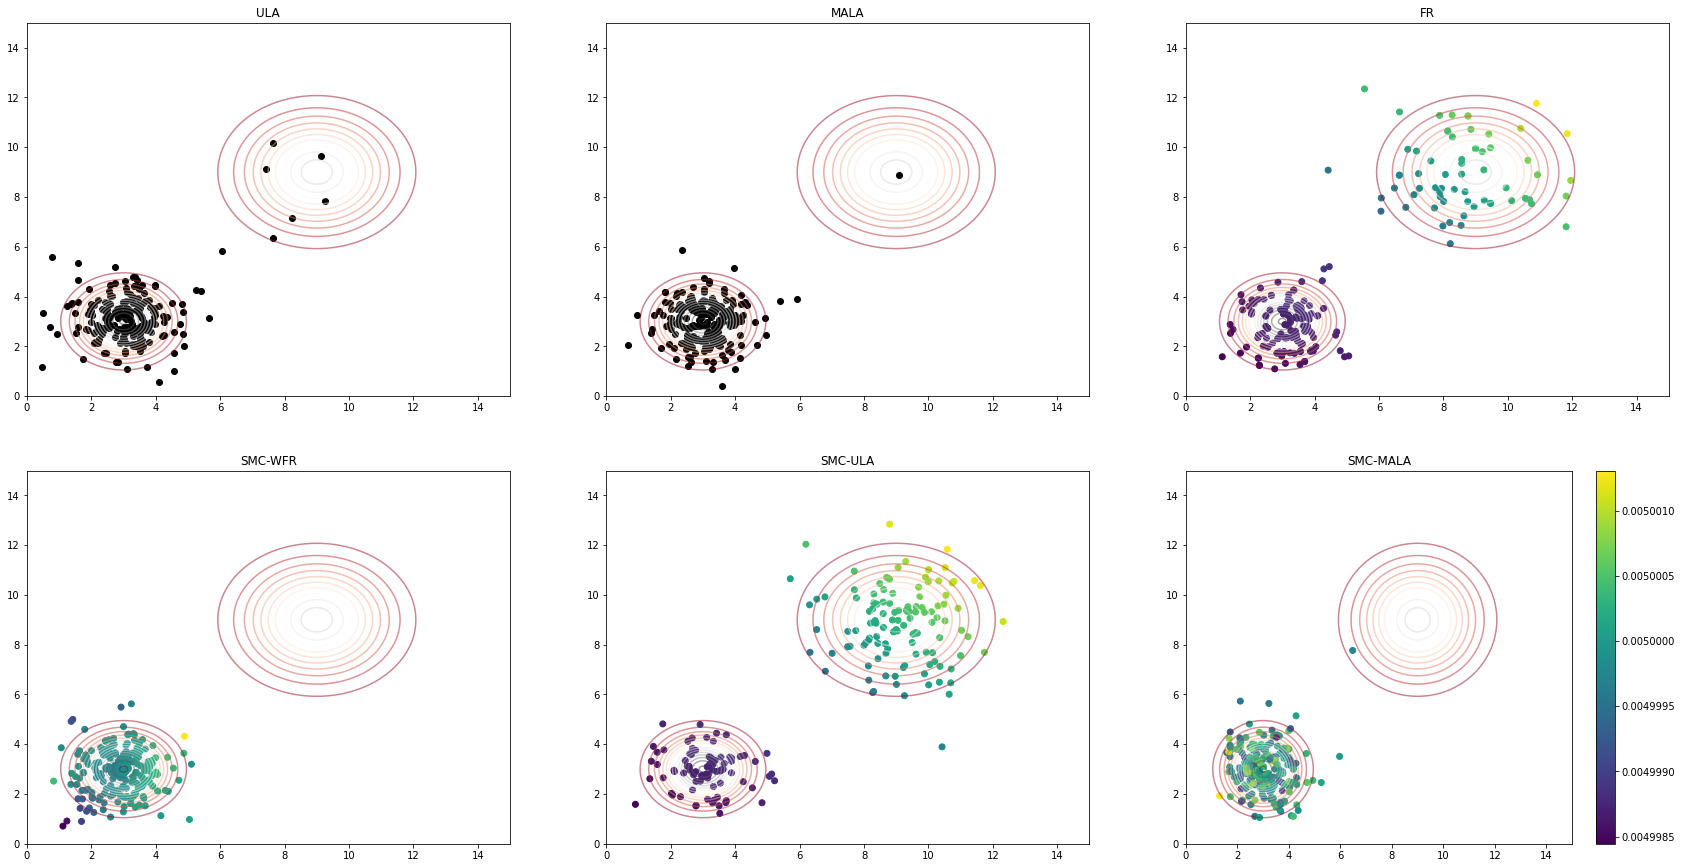

In [12]:
i = Nrep-1
plt.figure(figsize = (12,6))
plt.subplot(2, 3, 1)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(ula_chain[i, -1, 0, :], ula_chain[i, -1, 1, :], color = 'black');
plt.title('ULA')
plt.subplot(2, 3, 2)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(mala_chain[i, -1, 0, :], mala_chain[i, -1, 1, :], color = 'black');
plt.title('MALA')
plt.subplot(2, 3, 3)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(fr_x[i, -1, 0, :], fr_x[i, -1, 1, :], c = fr_w[i, -1, :]);
plt.title('FR')
plt.subplot(2, 3, 4)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(wfr_x[i, -1, 0, :], wfr_x[i, -1, 1, :], c = wfr_w[i, -1, :]);
plt.title('SMC-WFR')
plt.subplot(2, 3, 5)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(smcula_x[i, -1, 0, :], smcula_x[i, -1, 1, :], c = smcula_w[i, -1, :]);
plt.title('SMC-ULA')
plt.subplot(2, 3, 6)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(smcmala_x[i, -1, 0, :], smcmala_x[i, -1, 1, :], c = smcmala_w[i, -1, :]);
plt.title('SMC-MALA')
plt.colorbar();
plt.subplots_adjust(left=-1,
                    bottom=-1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)
plt.show()
# plt.savefig("GaussianMixture4Modes.pdf")

In [13]:
xx_ula = avg_runtime[0]/Niter_ula*np.arange(Niter_ula)
xx_mala = avg_runtime[1]/Niter_mala*np.arange(Niter_mala)
xx_fr = avg_runtime[2]/Niter_fr*np.arange(Niter_fr)
xx_wfr = avg_runtime[3]/Niter*np.arange(Niter)
xx_smcula = avg_runtime[4]/Niter_smcula*np.arange(Niter_smcula)
xx_smcmala = avg_runtime[5]/Niter_smcmala*np.arange(Niter_smcmala)

In [14]:
ksd_ula = np.zeros((Nrep, Niter_ula))
ksd_mala = np.zeros((Nrep, Niter_mala))
ksd_fr = np.zeros((Nrep, Niter_fr))
ksd_wfr = np.zeros((Nrep, Niter))
ksd_smcula = np.zeros((Nrep, Niter_smcula))
ksd_smcmala = np.zeros((Nrep, Niter_smcmala))

In [15]:
for j in range(Nrep):
    for i in range(Niter_ula):
        score_ula = algo.gradient_mixture(ula_chain[j, i, :, :], ms, Sigmas, weights)
        ksd_ula[j, i] = u.kernel_stein_discrepancy_imq_weighted(ula_chain[j, i, :, :].T, score_ula.T)
    for i in range(Niter_mala):
            score_mala = algo.gradient_mixture(mala_chain[j, i, :, :], ms, Sigmas, weights)
            ksd_mala[j, i] = u.kernel_stein_discrepancy_imq_weighted(mala_chain[j, i, :, :].T, score_mala.T)
    for i in range(Niter):
        score_wfr = algo.gradient_mixture(wfr_x[j, i, :, :], ms, Sigmas, weights)
        ksd_wfr[j, i] = u.kernel_stein_discrepancy_imq_weighted(wfr_x[j, i, :, :].T, score_wfr.T, weights = wfr_w[j, i, :])
    for i in range(Niter_fr):
        score_fr = algo.gradient_mixture(fr_x[j, i, :, :], ms, Sigmas, weights)
        ksd_fr[j, i] = u.kernel_stein_discrepancy_imq_weighted(fr_x[j, i, :, :].T, score_fr.T, weights = fr_w[j, i, :])
    for i in range(Niter_smcula):
        score_smcula = algo.gradient_mixture(smcula_x[j, i, :, :], ms, Sigmas, weights)
        ksd_smcula[j, i] = u.kernel_stein_discrepancy_imq_weighted(smcula_x[j, i, :, :].T, score_smcula.T, weights = smcula_w[j, i, :])
    for i in range(Niter_smcmala):
        score_smcmala = algo.gradient_mixture(smcmala_x[j, i, :, :], ms, Sigmas, weights)
        ksd_smcmala[j, i] = u.kernel_stein_discrepancy_imq_weighted(smcmala_x[j, i, :, :].T, score_smcmala.T, weights = smcmala_w[j, i, :])
    
    

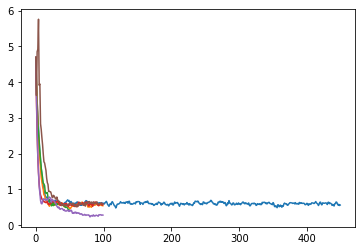

In [16]:
plt.plot(np.mean(ksd_ula, axis = 0))
plt.plot(np.mean(ksd_mala, axis = 0))
plt.plot(np.mean(ksd_fr, axis = 0))
plt.plot(np.mean(ksd_wfr, axis = 0))
plt.plot(np.mean(ksd_smcula, axis = 0))
plt.plot(np.mean(ksd_smcmala, axis = 0))

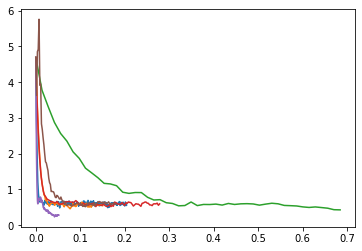

In [17]:
plt.plot(xx_ula, np.mean(ksd_ula, axis = 0))
plt.plot(xx_mala, np.mean(ksd_mala, axis = 0))
plt.plot(xx_fr, np.mean(ksd_fr, axis = 0))
plt.plot(xx_wfr, np.mean(ksd_wfr, axis = 0))
plt.plot(xx_smcula, np.mean(ksd_smcula, axis = 0))
plt.plot(xx_smcmala, np.mean(ksd_smcmala, axis = 0))